In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from stefcal_uvdata import StefcalUVData
from data import DATA_PATH
import matplotlib.pyplot as plt

In this notebook, we test the time-averaging of calibration solutions and whether the noise properties of the calibration solutions make sense. If the thermal noise on a single visibility and time-sample is given by $\sigma_N$, then the thermal noise on a calibration solution with a point-source calibrator with flux $S_0$ for an array of $N_{ant}$ antennas is given by
\begin{equation}
\sigma_g=\frac{\sigma_N}{S_0}\frac{1}{\sqrt{N_t(N_{ant}-1)}}
\end{equation}
In this simulation we will check that this relationship by performing calibration on a simulated VLA measurement. 

In [2]:
#initialize stefcal object 
stefcal_no_avg=StefcalUVData()
measured_vis=os.path.join(DATA_PATH,
                         'point_source_sim_measurement.uvfits')
model_vis=os.path.join(DATA_PATH,
                       'point_source_sim_model.uvfits')
#read in uvfits data and model files
stefcal_no_avg.from_uvfits(measured_vis,model_vis,
                           flag_weights_fromdata=True)
#set calibration parameters
stefcal_no_avg.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':1,
                           'n_phase_iter':0,
                           'refant':0})      
#run calibration
stefcal_no_avg.stefcalibrate()

Telescope VLA is not in known_telescopes.
boolean index did not match indexed array along dimension 0; dimension is 27 but corresponding boolean dimension is 1


Now that we have run a round of calibration, lets inspect
the noise on each baseline. Since the model is a point-source at zenith, there is very little change in the true visibility with time, even across all time intervals. Taking the standard deviation across all baselines and times gives us a number that is within good agreement with the noise estimate arrived upon by differencing adjacent time stamps and averaging the square of this difference across all baselines and adjacent time-step differences ($1\,\%$ agreement). 


-1.1-percent difference in estimated noises


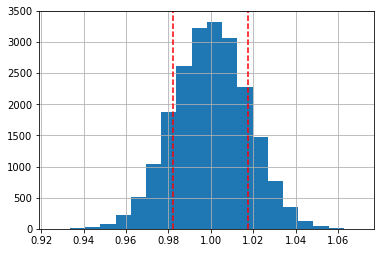

In [3]:
data_select=\
stefcal_no_avg.measured_vis.time_array==stefcal_no_avg.uvcal.time_array[0]
data_select[:]=True
plt.hist(np.real(stefcal_no_avg.measured_vis.data_array[data_select].flatten()),bins=20)
std_data=np.std(np.real(stefcal_no_avg.measured_vis.data_array[data_select].flatten()))
std_diffed=np.sqrt(stefcal_no_avg.meta_params.noise_tblavg)/np.sqrt(2.)
print('%.1f-percent difference in estimated noises'%(100.*(1.-std_diffed/std_data)[0]))
plt.axvline(1-std_diffed,color='r',ls='--')
plt.axvline(1+std_diffed,color='r',ls='--')
plt.grid()

Now lets compute the standard deviation of gain estimates. Since all of the true-gains are equal to identity in this simulation, their standard deviations will reflect the noise in the gain solutions. We find excellent (0.1%) agreement between the standard deviation in the gain solutions and the standard deviation predicted by 
\begin{equation}
\sigma_g=\frac{\sigma_N}{S_0}\frac{1}{\sqrt{N_t(N_{ant}-1)}}
\end{equation}

0.1-percent difference in estimated noises


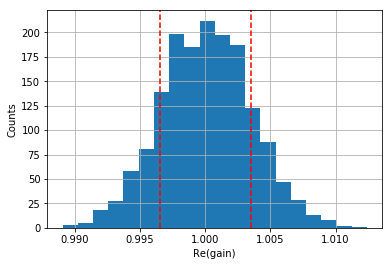

In [4]:
plt.hist(np.real(stefcal_no_avg.uvcal.gain_array.flatten()),bins=20)
plt.xlabel('Re(gain)')
plt.ylabel('Counts')
plt.grid()
gain_std_est=std_diffed/np.sqrt(stefcal_no_avg.uvcal.Nants_data-1.)
gain_std_re=np.std(np.real(stefcal_no_avg.uvcal.gain_array.flatten()))
gain_std_im=np.std(np.real(stefcal_no_avg.uvcal.gain_array.flatten()))
print('%.1f-percent difference in estimated noises'%(100.*(1.-gain_std_re/gain_std_est)[0]))
plt.axvline(1-gain_std_est,color='r',ls='--')
plt.axvline(1+gain_std_est,color='r',ls='--')

# Testing Time Averaging. 

Now we investigate averaging calibration solutions over multiple times. We start by averaging over 3 time-samples per solution which should reduce the noise by a factor of $\approx 1.7$. 

In [6]:
#initialize stefcal object 
stefcal_3_avg=StefcalUVData()
measured_vis=os.path.join(DATA_PATH,
                         'point_source_sim_measurement.uvfits')
model_vis=os.path.join(DATA_PATH,
                       'point_source_sim_model.uvfits')
#read in uvfits data and model files
stefcal_3_avg.from_uvfits(measured_vis,model_vis,
                           flag_weights_fromdata=True)
#set calibration parameters
stefcal_3_avg.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':1,
                           'n_phase_iter':0,
                           'refant':0,
                           't_avg':3})
#run calibration
stefcal_3_avg.stefcalibrate()

boolean index did not match indexed array along dimension 0; dimension is 27 but corresponding boolean dimension is 3


There is only a 0.2\% difference between the noise on the 3-time step averaged solutions
and the predicted interval!

-0.2-percent difference in estimated noises


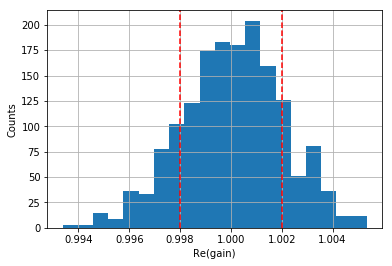

In [12]:
plt.hist(np.real(stefcal_3_avg.uvcal.gain_array.flatten()),bins=20)



plt.xlabel('Re(gain)')
plt.ylabel('Counts')
plt.grid()
gain_std_est=std_diffed/np.sqrt(3*(stefcal_3_avg.uvcal.Nants_data-1.))
gain_std_re=np.std(np.real(stefcal_3_avg.uvcal.gain_array.flatten()))
gain_std_im=np.std(np.real(stefcal_3_avg.uvcal.gain_array.flatten()))
print('%.1f-percent difference in estimated noises'%(100.*(1.-gain_std_re/gain_std_est)[0]))
plt.axvline(1-gain_std_est,color='r',ls='--')
plt.axvline(1+gain_std_est,color='r',ls='--')

Here is a comparison between the two distributions. 

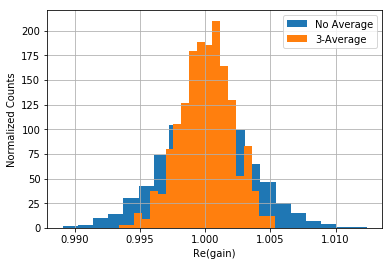

In [15]:
plt.hist(np.real(stefcal_no_avg.uvcal.gain_array.flatten()),bins=20,normed=True,label='No Average')
plt.hist(np.real(stefcal_3_avg.uvcal.gain_array.flatten()),bins=20,normed=True,label='3-Average')



plt.xlabel('Re(gain)')
plt.ylabel('Normalized Counts')
plt.grid()
plt.legend(loc='best')

Try averaging 10 just for fun. 

In [16]:
#initialize stefcal object 
stefcal_10_avg=StefcalUVData()
measured_vis=os.path.join(DATA_PATH,
                         'point_source_sim_measurement.uvfits')
model_vis=os.path.join(DATA_PATH,
                       'point_source_sim_model.uvfits')
#read in uvfits data and model files
stefcal_10_avg.from_uvfits(measured_vis,model_vis,
                           flag_weights_fromdata=True)
#set calibration parameters
stefcal_10_avg.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':1,
                           'n_phase_iter':0,
                           'refant':0,
                           't_avg':10})
#run calibration
stefcal_10_avg.stefcalibrate()

boolean index did not match indexed array along dimension 0; dimension is 27 but corresponding boolean dimension is 10


There is a larger (1-percent) discrepency due to smaller numbers of gain-samples due to increased averaging but still good agreement. 

1.4-percent difference in estimated noises


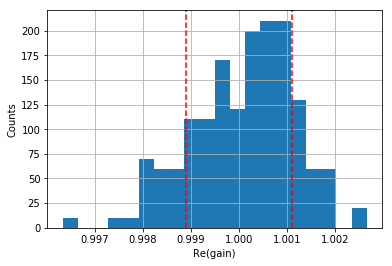

In [19]:
plt.hist(np.real(stefcal_10_avg.uvcal.gain_array.flatten()),bins=20)



plt.xlabel('Re(gain)')
plt.ylabel('Counts')
plt.grid()
gain_std_est=std_diffed/np.sqrt(10*(stefcal_10_avg.uvcal.Nants_data-1.))
gain_std_re=np.std(np.real(stefcal_10_avg.uvcal.gain_array.flatten()))
gain_std_im=np.std(np.real(stefcal_10_avg.uvcal.gain_array.flatten()))
print('%.1f-percent difference in estimated noises'%(100.*(1.-gain_std_re/gain_std_est)[0]))
plt.axvline(1-gain_std_est,color='r',ls='--')
plt.axvline(1+gain_std_est,color='r',ls='--')

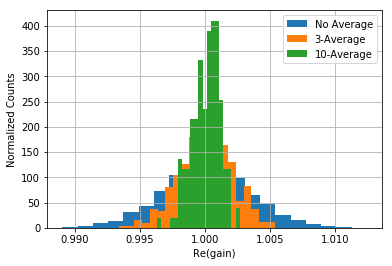

In [18]:
plt.hist(np.real(stefcal_no_avg.uvcal.gain_array.flatten()),bins=20,normed=True,label='No Average')
plt.hist(np.real(stefcal_3_avg.uvcal.gain_array.flatten()),bins=20,normed=True,label='3-Average')
plt.hist(np.real(stefcal_10_avg.uvcal.gain_array.flatten()),bins=20,normed=True,label='10-Average')




plt.xlabel('Re(gain)')
plt.ylabel('Normalized Counts')
plt.grid()
plt.legend(loc='best')